In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
import DataPreprocessing

# Spark session

In [2]:
spark = SparkSession.builder.appName('DataPreprocessing').getOrCreate()
sc=spark.sparkContext

# Reading the data

In [4]:
df = DataPreprocessing.read_data(spark,file_name='Google-Playstore')
df.show(5)

+--------------------+--------------------+-------------+------+------------+--------+----------------+----------------+----+-----+--------+----+---------------+--------------------+--------------------+--------------------+------------+------------+--------------+--------------------+------------+----------------+--------------+-------------------+
|            App Name|              App Id|     Category|Rating|Rating Count|Installs|Minimum Installs|Maximum Installs|Free|Price|Currency|Size|Minimum Android|        Developer Id|   Developer Website|     Developer Email|    Released|Last Updated|Content Rating|      Privacy Policy|Ad Supported|In App Purchases|Editors Choice|       Scraped Time|
+--------------------+--------------------+-------------+------+------------+--------+----------------+----------------+----+-----+--------+----+---------------+--------------------+--------------------+--------------------+------------+------------+--------------+--------------------+----------

# Get info about the data

In [5]:
DataPreprocessing.get_info(df)

Number of rows: 2312944, Number of columns: 24
+-------+--------------------+--------------------+--------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-----------------+--------------------+---------------+------------------+---------------+-----------------------+--------------------+--------------------+--------------------+-------------------+
|summary|            App Name|              App Id|      Category|            Rating|      Rating Count|          Installs|  Minimum Installs|  Maximum Installs|              Free|             Price|          Currency|              Size|   Minimum Android|        Developer Id|Developer Website|     Developer Email|       Released|      Last Updated| Content Rating|         Privacy Policy|        Ad Supported|    In App Purchases|      Editors Choice|       Scraped Time|
+--

# Explore some columns

## Size

In [6]:
DataPreprocessing.check_values_in_size_col(df)

Percentage of apps with size "Varies with device": 3.232936033038413 %


In [7]:
print('The percentage of "Varies with app" is too low, then can remove all rows with this value')

The percentage of "Varies with app" is too low, then can remove all rows with this value


In [8]:
df= DataPreprocessing.convert_size_to_bytes(df)

## Scraped time

In [9]:
DataPreprocessing.check_scraped_time(df)

+------------+-------+
|Scraped Time|  count|
+------------+-------+
|  2021-06-16|1799349|
|  2021-06-15| 438579|
|       False|     43|
|        True|      1|
+------------+-------+



In [10]:
print("Most of the apps were scrapped in the same 2 days, then we can remove this column.")

Most of the apps were scrapped in the same 2 days, then we can remove this column.


In [11]:
df = DataPreprocessing.remove_useless_col(df, ['Scraped time'])

# Outliers

In [12]:
new_df= DataPreprocessing.detect_outliers(df)

Number of outliers in Rating: 0 (0.00%)
Number of outliers in Rating Count: 378146 (16.90%)
Number of outliers in Installs: 244067 (10.91%)
Number of outliers in Minimum Installs: 244067 (10.91%)
Number of outliers in Maximum Installs: 392614 (17.54%)
Number of outliers in Price: 42545 (1.90%)
Number of outliers in Size: 120073 (5.37%)
Number of rows before removing outliers: 2237972
Number of rows after removing those having more than 1 outlier in its columns: 1890342


### Display boxplot for numerical columns before and after removing the outliers

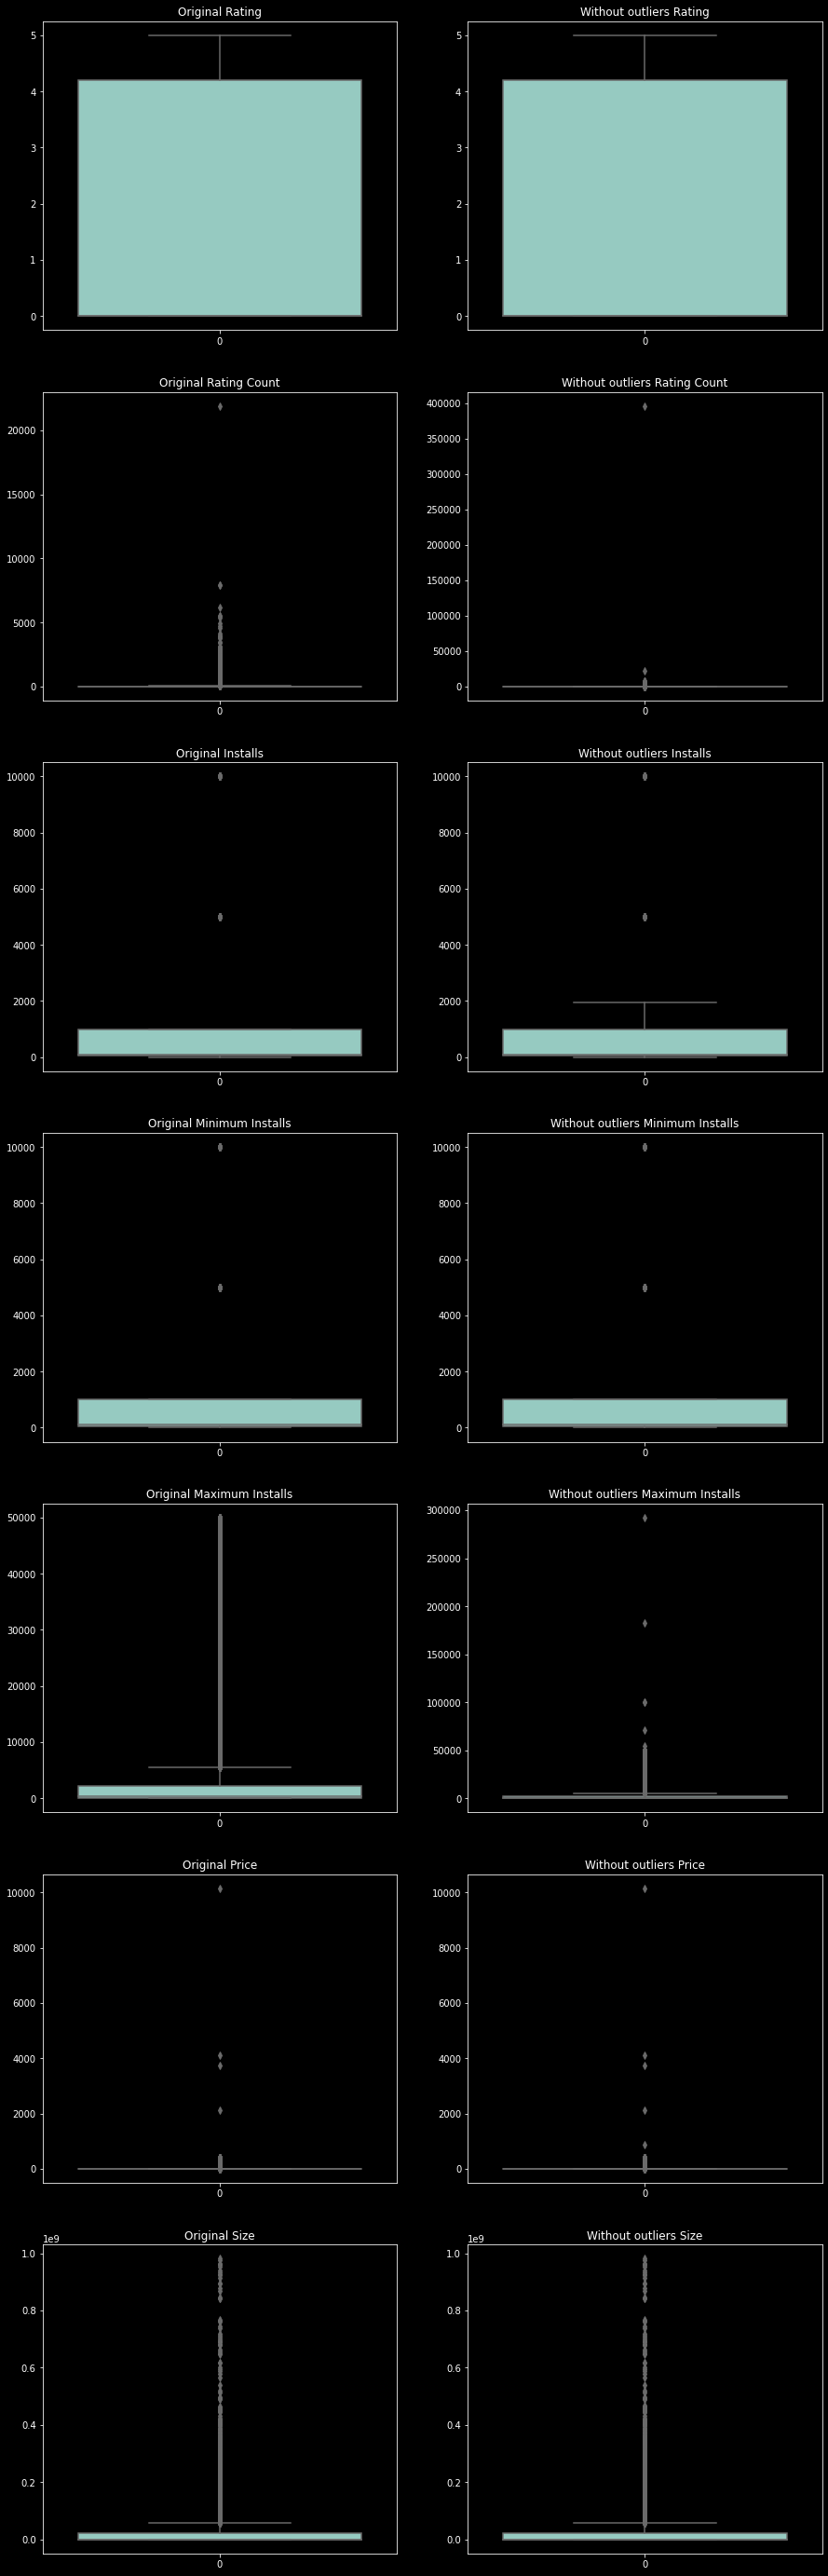

In [33]:

DataPreprocessing.boxplot_for_outliers(df, new_df)

### Safely remove the outliers

In [14]:
df= new_df

# Missing values

In [15]:
DataPreprocessing.show_nulls(df) 

                    count  percentage
Developer Website  655601   34.681608
Privacy Policy     367923   19.463303
Released            38418    2.032331
Minimum Android      5839    0.308886
Size                  868    0.045918
Rating                836    0.044225
Rating Count          817    0.043220
Currency               46    0.002433
Minimum Installs       45    0.002381
Developer Id           30    0.001587
Installs               26    0.001375
Developer Email        21    0.001111
Price                  19    0.001005
Maximum Installs       10    0.000529
Ad Supported            4    0.000212
In App Purchases        2    0.000106
Content Rating          0    0.000000
App Name                0    0.000000
Last Updated            0    0.000000
App Id                  0    0.000000
Free                    0    0.000000
Category                0    0.000000
Editors Choice          0    0.000000


## Handle missing values

### Remove columns with high percentages of nulls

In [16]:
df= DataPreprocessing.remove_useless_col(df,['Developer Website','Privacy Policy'])

### For Currency column

In [17]:
DataPreprocessing.currency_col(df)

+--------+-------+
|Currency|  count|
+--------+-------+
|     USD|1889100|
|     XXX|   1145|
|    null|     46|
|       0|     18|
|    True|     10|
|     EUR|      6|
|     INR|      5|
|     GBP|      3|
|     CAD|      2|
|     BRL|      1|
|     KRW|      1|
|     TRY|      1|
|     ZAR|      1|
|     AUD|      1|
|    1.99|      1|
|     SGD|      1|
+--------+-------+



In [18]:
print("Since most of the values are USD, then we can remove this column,")
df = DataPreprocessing.remove_useless_col(df, ['Currency'])
print(f"Columns after removing useless columns:{df.columns}")

Since most of the values are USD, then we can remove this column,
Columns after removing useless columns:['App Name', 'App Id', 'Category', 'Rating', 'Rating Count', 'Installs', 'Minimum Installs', 'Maximum Installs', 'Free', 'Price', 'Size', 'Minimum Android', 'Developer Id', 'Developer Email', 'Released', 'Last Updated', 'Content Rating', 'Ad Supported', 'In App Purchases', 'Editors Choice']


### Removes rows with nulls in Uninteresting columns

In [19]:
uninteresting_cols= ['Minimum Android','Size','Minimum Installs','Installs','Developer Email',\
                   'Developer Id','Price','Ad Supported','In App Purchases']

df=DataPreprocessing.handle_missing_values(df,cols=uninteresting_cols)

Total Number of rows : 1890342
Number of rows after dropping nulls: 1883566


### Fill rows with nulls in interesting columns

In [20]:
interesting_num_cols=['Rating','Rating Count','Maximum Installs']
df= DataPreprocessing.handle_missing_values(df, handling_method='mean', cols=interesting_num_cols)

Total Number of rows : 1883566


In [21]:
interesting_cat_cols=['Released']
df= DataPreprocessing.handle_missing_values(df, handling_method='mode', cols=interesting_cat_cols)

Total Number of rows : 1883566


In [22]:
DataPreprocessing.show_nulls(df)

                  count  percentage
App Name              0         0.0
App Id                0         0.0
In App Purchases      0         0.0
Ad Supported          0         0.0
Content Rating        0         0.0
Last Updated          0         0.0
Released              0         0.0
Developer Email       0         0.0
Developer Id          0         0.0
Minimum Android       0         0.0
Size                  0         0.0
Price                 0         0.0
Free                  0         0.0
Maximum Installs      0         0.0
Minimum Installs      0         0.0
Installs              0         0.0
Rating Count          0         0.0
Rating                0         0.0
Category              0         0.0
Editors Choice        0         0.0


# Final dataframe

In [23]:
DataPreprocessing.get_info(df)

Number of rows: 1883566, Number of columns: 20
+-------+--------------------+--------------------+--------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+--------------------+--------------------+---------------+------------------+---------------+--------------------+--------------------+--------------+
|summary|            App Name|              App Id|      Category|            Rating|     Rating Count|          Installs|  Minimum Installs|  Maximum Installs|              Free|              Price|                Size|   Minimum Android|        Developer Id|     Developer Email|       Released|      Last Updated| Content Rating|        Ad Supported|    In App Purchases|Editors Choice|
+-------+--------------------+--------------------+--------------+------------------+-----------------+------------------+------------------+------------------+-------------

In [24]:
df.dtypes

[('App Name', 'string'),
 ('App Id', 'string'),
 ('Category', 'string'),
 ('Rating', 'float'),
 ('Rating Count', 'int'),
 ('Installs', 'int'),
 ('Minimum Installs', 'int'),
 ('Maximum Installs', 'int'),
 ('Free', 'string'),
 ('Price', 'float'),
 ('Size', 'float'),
 ('Minimum Android', 'string'),
 ('Developer Id', 'string'),
 ('Developer Email', 'string'),
 ('Released', 'string'),
 ('Last Updated', 'string'),
 ('Content Rating', 'string'),
 ('Ad Supported', 'string'),
 ('In App Purchases', 'string'),
 ('Editors Choice', 'string')]